Нейроконсультант по ТЕХНИЧЕСКОМУ РЕГЛАМЕНТУ ТАМОЖЕННОГО СОЮЗА "О БЕЗОПАСНОСТИ ЖЕЛЕЗНОДОРОЖНОГО ПОДВИЖНОГО СОСТАВА"

In [ ]:
!pip install -q langchain_openai==0.0.2 faiss-cpu==1.7.4 openai==1.6.1 tiktoken==0.5.2 langchain_community==0.0.11 langchain==0.1.0 cohere
!pip install pydantic pydantic-settings

In [8]:
import os
from openai import OpenAI
from langchain_openai import OpenAIEmbeddings
from langchain.vectorstores import FAISS
import requests
import re
from langchain.text_splitter import MarkdownHeaderTextSplitter, RecursiveCharacterTextSplitter
import matplotlib.pyplot as plt
import tiktoken
from langchain.docstore.document import Document

from pydantic import SecretStr
from pydantic_settings import BaseSettings, SettingsConfigDict

class Settings(BaseSettings):
    model_config = SettingsConfigDict(env_file='input',
                                      env_file_encoding='utf-8')
    openai_api_key: SecretStr


os.environ['OPENAI_API_KEY'] = Settings().openai_api_key.get_secret_value()
client = OpenAI()

In [ ]:
# функция для загрузки документа по ссылке из гугл драйв
def load_document_text(url: str) -> str:
    # Extract the document ID from the URL
    match_ = re.search('/document/d/([a-zA-Z0-9-_]+)', url)
    if match_ is None:
        raise ValueError('Invalid Google Docs URL')
    print(match_)
    print(match_.group(1))
    doc_id = match_.group(1)
    # Download the document as plain text
    response = requests.get(f'https://docs.google.com/document/d/{doc_id}/export?format=txt')
    response.raise_for_status()
    return response.text

# База данных
data_from_url= load_document_text('https://docs.google.com/document/d/1YhUEX4kZDNTeE3eJ-yXskxZG46Ls47FvXjZ9Ij-t8Rw/edit?usp=sharing') # изменена

In [ ]:
def text_to_markdown(text):
    # Добавляем заголовок 1 уровня на основе римских чисел (без переноса строки)
    # и дублируем его строчкой ниже - иначе эта информация перенесется в метаданные, а порой она бывает полезной.
    def replace_header1(match):
        print(match.group(2))
        return f"# {match.group(2)}\n{match.group(2)}"
    text = re.sub(r'^(I{1,3}|IV|V|VI{1,3}|IX)\. (.+)', replace_header1, text, flags=re.M)

    # Добавляем текст, выделенный жирным шрифтом (он заключен между *)
    # и дублируем его строчкой ниже
    def replace_header2(match):
        print(match.group(1))
        return f"## {match.group(1)}\n{match.group(1)}"
    text = re.sub(r'\*([^\*]+)\*', replace_header2, text)
    return text

markdown = text_to_markdown(data_from_url)


Fragment Token Counts: [106, 990, 6934, 489, 231, 20029, 839, 25454, 653, 10082] 



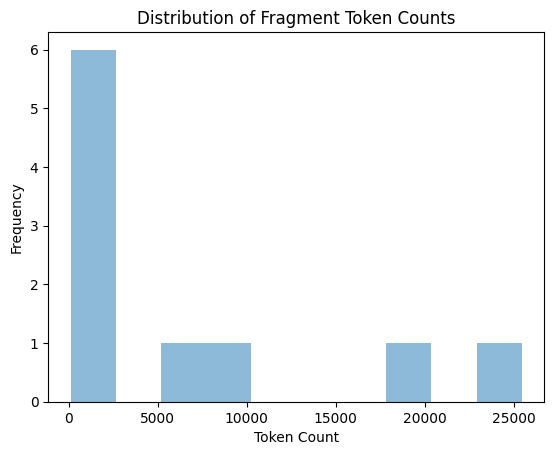


Source Chunk Token Counts: [106, 629, 361, 677, 699, 670, 634, 731, 623, 522, 712, 687, 680, 299, 489, 231, 640, 670, 615, 703, 690, 727, 709, 667, 648, 688, 716, 723, 652, 705, 710, 580, 695, 741, 605, 738, 734, 698, 729, 718, 647, 720, 732, 699, 730, 680, 159, 672, 683, 730, 716, 720, 715, 676, 658, 617, 628, 718, 719, 675, 732, 604, 729, 539, 702, 645, 731, 664, 729, 708, 534, 678, 678, 692, 716, 698, 715, 676, 633, 655, 655, 523, 666, 721, 504, 653, 708, 728, 716, 736, 732, 737, 715, 674, 726, 741, 707, 720, 743, 689] 



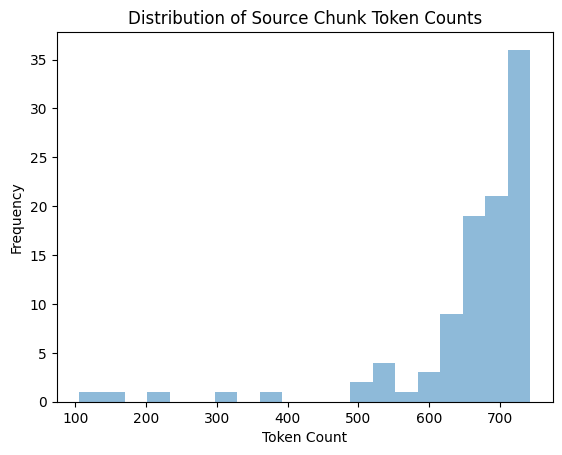

fragments:  10
source_chunks:  100


In [11]:
def num_tokens_from_string(string: str, encoding_name: str) -> int:
      """Возвращает количество токенов в строке"""
      encoding = tiktoken.get_encoding(encoding_name)
      num_tokens = len(encoding.encode(string))
      return num_tokens

def split_text(text, max_count):
    headers_to_split_on = [
        ("#", "Header 1"),
        ("##", "Header 2"),
    ]
    markdown_splitter = MarkdownHeaderTextSplitter(headers_to_split_on=headers_to_split_on)
    fragments = markdown_splitter.split_text(text)

    # Подсчет токенов для каждого фрагмента и построение графика
    fragment_token_counts = [num_tokens_from_string(fragment.page_content, "cl100k_base") for fragment in fragments]
    print('\nFragment Token Counts:', fragment_token_counts, '\n')

    plt.hist(fragment_token_counts, bins=10, alpha=0.5, label='Fragments')
    plt.title('Distribution of Fragment Token Counts')
    plt.xlabel('Token Count')
    plt.ylabel('Frequency')
    plt.show()

    splitter = RecursiveCharacterTextSplitter(
        chunk_size=max_count,
        chunk_overlap=0,
        length_function=lambda x: num_tokens_from_string(x, "cl100k_base")
    )
    source_chunks = [
        Document(page_content=chunk, metadata=fragment.metadata)
        for fragment in fragments
        for chunk in splitter.split_text(fragment.page_content)
    ]
    # Подсчет токенов для каждого source_chunk и построение графика
    source_chunk_token_counts = [num_tokens_from_string(chunk.page_content, "cl100k_base") for chunk in source_chunks]
    print('\nSource Chunk Token Counts:', source_chunk_token_counts, '\n')

    plt.hist(source_chunk_token_counts, bins=20, alpha=0.5, label='Source Chunks')
    plt.title('Distribution of Source Chunk Token Counts')
    plt.xlabel('Token Count')
    plt.ylabel('Frequency')
    plt.show()
    return source_chunks, fragments


source_chunks, fragments = split_text(markdown, 750)
print("fragments: ", len(fragments))
print("source_chunks: ", len(source_chunks))

In [12]:
embeddings = OpenAIEmbeddings()
db = FAISS.from_documents(source_chunks, embeddings)

query = "Чем должен быть оборудован моторвагонный подвижной состав?"
docs_and_scores = db.similarity_search_with_score(query, k=4)

print("№1:", docs_and_scores[0][0].page_content[:150], ' | ', docs_and_scores[0][1])
print("№2:", docs_and_scores[1][0].page_content[:150], ' | ', docs_and_scores[1][1])
print("№3:", docs_and_scores[2][0].page_content[:150], ' | ', docs_and_scores[2][1])
print("№4:", docs_and_scores[3][0].page_content[:150], ' | ', docs_and_scores[3][1])

№1: Прожектор должен быть установлен по продольной оси симметрии локомотива, головного вагона моторвагонного подвижного состава и специального самоходного  |  0.24472928
№2: 71. Локомотивы, моторвагонный подвижной состав, пассажирские вагоны, специальный железнодорожный подвижной состав и изотермические вагоны с автономной  |  0.2498666
№3: 53. Железнодорожный подвижной состав должен быть оборудован сцепным или автосцепным устройством. Конструкция такого устройства не должна вызывать само  |  0.25158235
№4: 84. Вагоны, предназначенные для перевозки продовольственного сырья и пищевых продуктов, должны обеспечивать температуру, влажность, показатели воздухо  |  0.2539165


In [ ]:
def answer_gpt(system, topic, db, temp=0, verbose=0):
    # Поиск релевантных отрезков из базы знаний
    # docs = db.similarity_search(topic, k=4)
    # message_content = ', '.join([doc.page_content for doc in docs])
    docs_and_scores = db.similarity_search_with_score(topic, k=4)
    message_content = ', '.join([doc[0].page_content for doc in docs_and_scores])
    scores = [doc[1] for doc in docs_and_scores]

    if verbose:
        print(' Message_content:\n', message_content)

    messages = [
        {"role": "system", "content": system},
        {"role": "user", "content": f"Ответь на вопрос. Документ с информацией для ответа: {message_content}\n\nВопрос: \n{topic}"}
    ]
    completion = client.chat.completions.create(
        model="gpt-3.5-turbo-1106",
        messages=messages,
        temperature=temp
    )
    print('Symbols Message_content:', len(message_content))
    print('Scores:', scores)
    print(f'Вопрос: {completion.usage.prompt_tokens} токенов. '
          f'\nОтвет: {completion.usage.completion_tokens} токенов. '
          f'\nВсего: {completion.usage.total_tokens} токенов.\n')
    return completion.choices[0].message.content


# Инструкция в system
system = "Ты консультант по ТЕХНИЧЕСКОМУ РЕГЛАМЕНТУ ТАМОЖЕННОГО СОЮЗА О БЕЗОПАСНОСТИ ЖЕЛЕЗНОДОРОЖНОГО ПОДВИЖНОГО СОСТАВА. \
Ответь на вопрос на основе Документа с информацией. Не придумывай ничего от себя, отвечай максимально \
по Документу. Не упоминай Документ с информацией при ответе. Никто ничего не должен знать про \
Документ с информацией для ответа. Ты должен отвечать на вопросы только по темам Документа с информацией. \
Ты не должен отвечать на вопросы, которые не связанны с темами, содержащимися в Документе с информацией. \
Если будет вопрос не связанный с темами Документа, ответь, что ты можешь отвечать на вопросы только \
о ТЕХНИЧЕСКОМ РЕГЛАМЕНТЕ ТАМОЖЕННОГО СОЮЗА О БЕЗОПАСНОСТИ ЖЕЛЕЗНОДОРОЖНОГО ПОДВИЖНОГО СОСТАВА"

In [ ]:
topic = "Чем должен быть оборудован моторвагонный подвижной состав?"
answer_gpt(system, topic, db)

Symbols Message_content: 6487
Scores: [0.24472928, 0.2498666, 0.25158238, 0.2539165]
Вопрос: 3262 токенов. 
Ответ: 140 токенов. 
Всего: 3402 токенов.



'Моторвагонный подвижной состав должен быть оборудован звуковыми сигнальными устройствами большой громкости (тифоны) и малой громкости (свистки), специальными местами для хранения комплекта электрозащитных средств, а также другого специального оборудования, необходимого для технического обслуживания и безопасной эксплуатации.'

In [ ]:
topic = "На что распространяются ТРЕБОВАНИЯ ТЕХНИЧЕСКОГО РЕГЛАМЕНТА \
ТАМОЖЕННОГО СОЮЗА О БЕЗОПАСНОСТИ ЖЕЛЕЗНОДОРОЖНОГО ПОДВИЖНОГО СОСТАВА ?"
answer_gpt(system, topic, db)

Symbols Message_content: 3629
Scores: [0.1323086, 0.20585328, 0.26421252, 0.26473594]
Вопрос: 2660 токенов. 
Ответ: 153 токенов. 
Всего: 2813 токенов.



'Требования Технического регламента Таможенного союза о безопасности железнодорожного подвижного состава распространяются на железнодорожный подвижной состав, включая локомотивы, моторвагонный подвижной состав и его вагоны, пассажирские вагоны локомотивной тяги, грузовые вагоны, специальный железнодорожный подвижной состав.'

In [ ]:
topic = "Ответь пожалуйста, как ты думаешь, есть ли жизнь на Марсе?"
answer_gpt(system, topic, db)

Symbols Message_content: 3806
Scores: [0.47398448, 0.5155029, 0.53266966, 0.5347254]
Вопрос: 2183 токенов. 
Ответ: 105 токенов. 
Всего: 2288 токенов.



'Я могу отвечать только на вопросы о ТЕХНИЧЕСКОМ РЕГЛАМЕНТЕ ТАМОЖЕННОГО СОЮЗА О БЕЗОПАСНОСТИ ЖЕЛЕЗНОДОРОЖНОГО ПОДВИЖНОГО СОСТАВА.'